# Цель и описание работы

## Описание работы:

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 

## Описание данных:

#### market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 * id — номер покупателя в корпоративной базе данных.
 * Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 * Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 * Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
 * Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 * Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 * Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 * Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 * Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 * Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 * Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 * Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 * Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

 * id — номер покупателя в корпоративной базе данных.
 * Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 * Выручка — сумма выручки за период.

#### market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 
 * id — номер покупателя в корпоративной базе данных.
 * Период — название периода, во время которого зафиксировано общее время.
 * минут — значение времени, проведённого на сайте, в минутах.

#### money.csv - Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

 * id — номер покупателя в корпоративной базе данных.
 * Прибыль — значение прибыли.
 
 
## Цель работы:

 * Разработайть модель, которая предскажет вероятность снижения покупательской активности.
 * Выделить сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Для этого необходимо использовать данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). 
 
#### Сегменты на выбор:
 
 * Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
 * Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
 * Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
 * Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

# Шаг 0. Any imports

In [6]:
!pip install --upgrade scikit-learn -q
!pip install --upgrade shap  -q
!pip install --upgrade pandas pandasai -q
!pip install matplotlib==3.7.3 -q
!pip install numpy==1.23.5 pyyaml -q
!pip install --upgrade numba -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro, kstest
import shap

/home/lam-ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Шаг 1. Загрузка данных

In [3]:
FileDF = pd.read_csv('./datasets/market_file.csv')
FileDF.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [3]:
FileDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
MMoneyDF = pd.read_csv('./datasets/market_money.csv')
MMoneyDF.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
MMoneyDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
TimeDF = pd.read_csv('./datasets/market_time.csv')
TimeDF.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
TimeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
MoneyDF = pd.read_csv('./datasets/money.csv', sep=';')
MoneyDF.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [9]:
MoneyDF['Прибыль'] = MoneyDF['Прибыль'].apply(lambda x: x.replace(',', '.'))
MoneyDF['Прибыль'] = MoneyDF['Прибыль'].astype(float)

In [10]:
MoneyDF.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [11]:
MoneyDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные успешно загружены. Типы данных приведены к правильным.

# Шаг 2. Предобработка данных

На этапе загрузки данных мы убедились, что в данных нет пропусков

Приведем названия столбцов в данных, а также сами категориальные данные, к одному виду

In [12]:
FileDF.columns = FileDF.columns.str.replace(' ', '_')
FileDF.columns = FileDF.columns.str.lower()
FileDF.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [13]:
for col_name in list(FileDF.columns):
    if FileDF[col_name].dtype == object:
        FileDF[col_name] = FileDF[col_name].str.replace(' ', '_')
        FileDF[col_name] = FileDF[col_name].str.lower()
        print(col_name) 
        print(FileDF[col_name].unique())

покупательская_активность
['снизилась' 'прежний_уровень']
тип_сервиса
['премиум' 'стандартт' 'стандарт']
разрешить_сообщать
['да' 'нет']
популярная_категория
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']


Видимо "стандартт" и "стандарт" в столбце "тип_сервиса", устраняем

In [14]:
FileDF['тип_сервиса'] = FileDF['тип_сервиса'].apply(lambda x: 'стандарт' if x == 'стандартт' else x)

In [15]:
for col_name in list(FileDF.columns):
    if FileDF[col_name].dtype == object:
        print(col_name) 
        print(FileDF[col_name].unique())

покупательская_активность
['снизилась' 'прежний_уровень']
тип_сервиса
['премиум' 'стандарт']
разрешить_сообщать
['да' 'нет']
популярная_категория
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']


In [16]:
MMoneyDF.columns = MMoneyDF.columns.str.replace(' ', '_')
MMoneyDF.columns = MMoneyDF.columns.str.lower()
MMoneyDF.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [17]:
for col_name in list(MMoneyDF.columns):
    if MMoneyDF[col_name].dtype == object:
        MMoneyDF[col_name] = MMoneyDF[col_name].str.replace(' ', '_')
        MMoneyDF[col_name] = MMoneyDF[col_name].str.lower()
        print(col_name) 
        print(MMoneyDF[col_name].unique())

период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [18]:
TimeDF.columns = TimeDF.columns.str.replace(' ', '_')
TimeDF.columns = TimeDF.columns.str.lower()
TimeDF.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [19]:
for col_name in list(TimeDF.columns):
    if TimeDF[col_name].dtype == object:
        TimeDF[col_name] = TimeDF[col_name].str.replace(' ', '_')
        TimeDF[col_name] = TimeDF[col_name].str.lower()
        print(col_name) 
        print(TimeDF[col_name].unique())

период
['текущий_месяц' 'предыдцщий_месяц']


Исправим орфографическую ошибку, дупущенную на этапе сбора данных

In [20]:
TimeDF['период'] = TimeDF['период'].apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)

In [21]:
for col_name in list(TimeDF.columns):
    if TimeDF[col_name].dtype == object:
        print(col_name) 
        print(TimeDF[col_name].unique())

период
['текущий_месяц' 'предыдущий_месяц']


In [22]:
MoneyDF.columns = MoneyDF.columns.str.replace(' ', '_')
MoneyDF.columns = MoneyDF.columns.str.lower()
MoneyDF.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Проверим данные на дубли

In [23]:
FileDF.duplicated().sum()

0

In [24]:
MMoneyDF.duplicated().sum()

0

In [25]:
TimeDF.duplicated().sum()

0

In [26]:
MoneyDF.duplicated().sum()

0

Дублей нет

В данном разделе были исправлены ошибки при сборе данных, связанные с правописанием. 

А также, названия столбцов, а также строковые данные, приведены к одному виду

# Шаг 3. Исследовательский анализ данных

Посмотрим на статистические признаки столбцов в данных

In [27]:
FileDF.drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [28]:
MMoneyDF.drop('id', axis=1).describe()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


In [29]:
MMoneyDF[MMoneyDF['выручка'] == MMoneyDF['выручка'].max()]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Возможно, при сборе данных произошла ошибка и запятая была поставлена не в том месте. Разделем данное значение на 10

In [30]:
MMoneyDF.loc[98, 'выручка'] = MMoneyDF.loc[98, 'выручка'] / 10

In [31]:
MMoneyDF.drop('id', axis=1).describe()

,выручка
count,3900.000000
mean,5001.035544
std,712.749887
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,10686.220000


In [32]:
TimeDF.drop('id', axis=1).describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


In [33]:
MoneyDF.drop('id', axis=1).describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Теперь, на первый взгляд, все выгляди разумно.

Посмотрим внимаиельнее на признаки

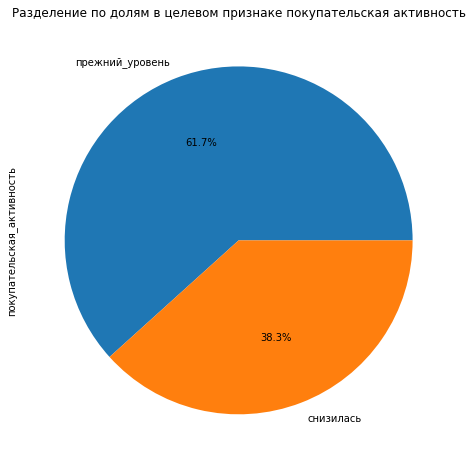

In [34]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в целевом признаке покупательская активность')
pie=FileDF['покупательская_активность'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

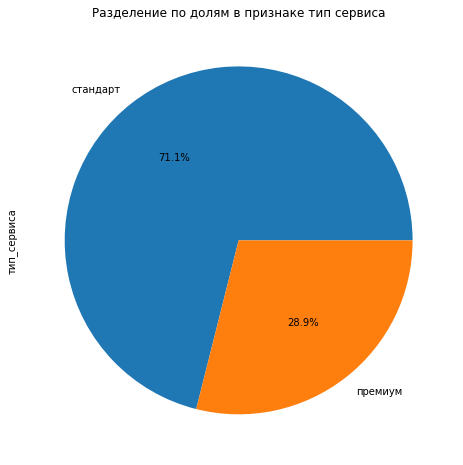

In [35]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке тип сервиса')
pie=FileDF['тип_сервиса'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

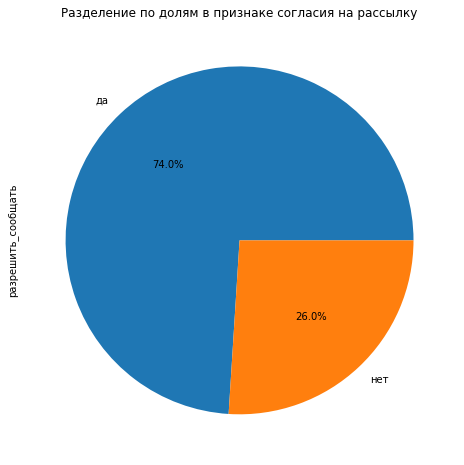

In [36]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке согласия на рассылку')
pie=FileDF['разрешить_сообщать'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

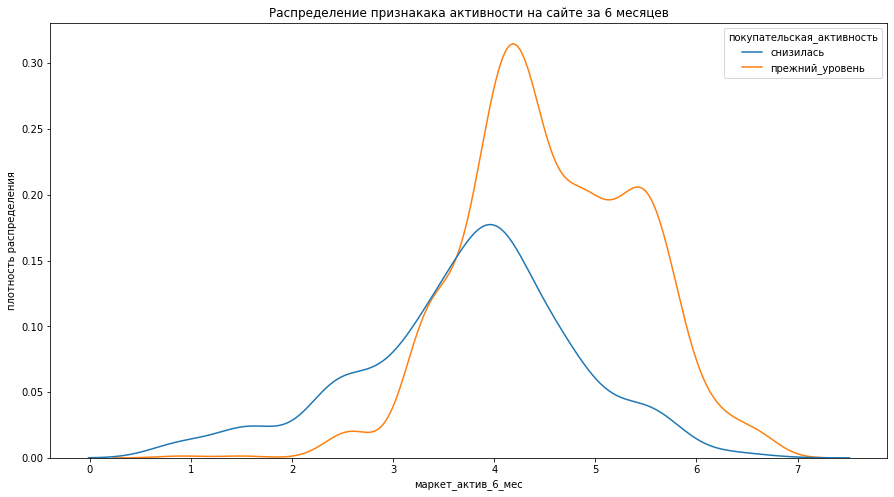

In [37]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=FileDF, x="маркет_актив_6_мес", hue="покупательская_активность")
plt.title('Распределение признакака активности на сайте за 6 месяцев')
plt.xlabel('маркет_актив_6_мес')
plt.ylabel('плотность распределения')
plt.show()

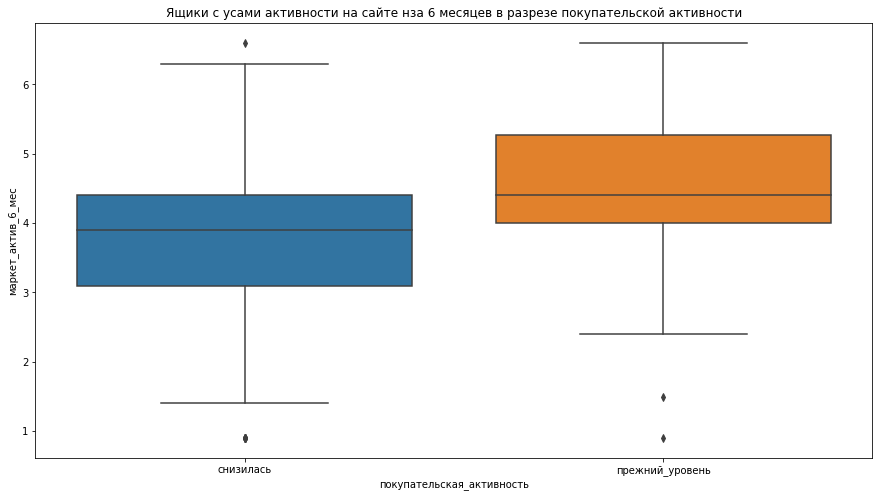

In [38]:
plt.figure(figsize=(15,8))
sns.boxplot(data=FileDF, x="покупательская_активность",  y="маркет_актив_6_мес")
plt.title('Ящики с усами активности на сайте нза 6 месяцев в разрезе покупательской активности')
plt.xlabel('покупательская_активность')
plt.ylabel('маркет_актив_6_мес')
plt.show()

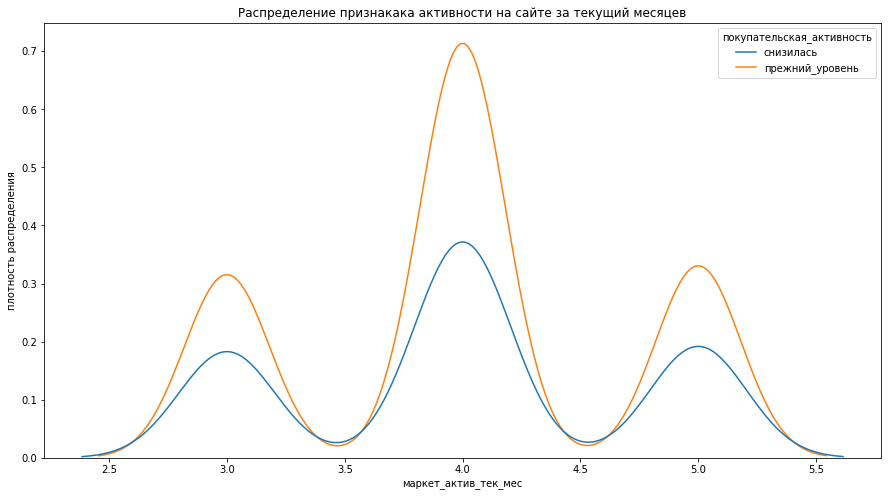

In [39]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=FileDF, x="маркет_актив_тек_мес", hue="покупательская_активность")
plt.title('Распределение признакака активности на сайте за текущий месяцев')
plt.xlabel('маркет_актив_тек_мес')
plt.ylabel('плотность распределения')
plt.show()

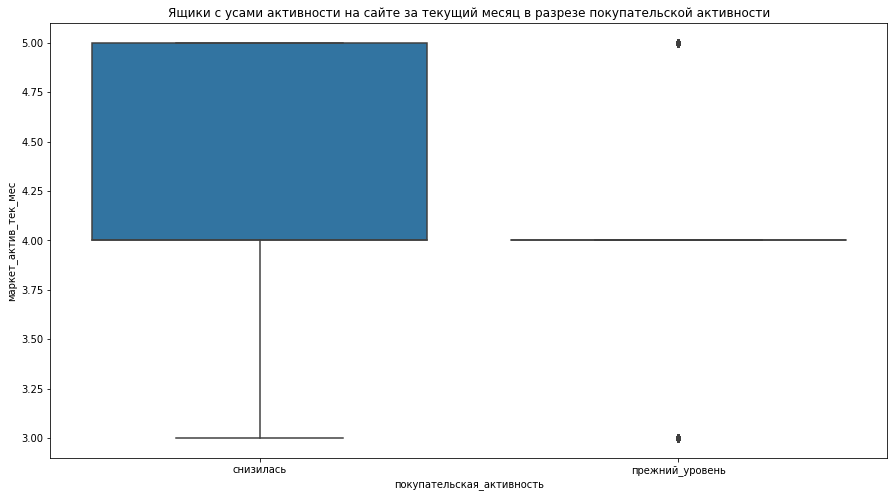

In [40]:
plt.figure(figsize=(15,8))
sns.boxplot(data=FileDF, x="покупательская_активность",  y="маркет_актив_тек_мес")
plt.title('Ящики с усами активности на сайте за текущий месяц в разрезе покупательской активности')
plt.xlabel('покупательская_активность')
plt.ylabel('маркет_актив_тек_мес')
plt.show()

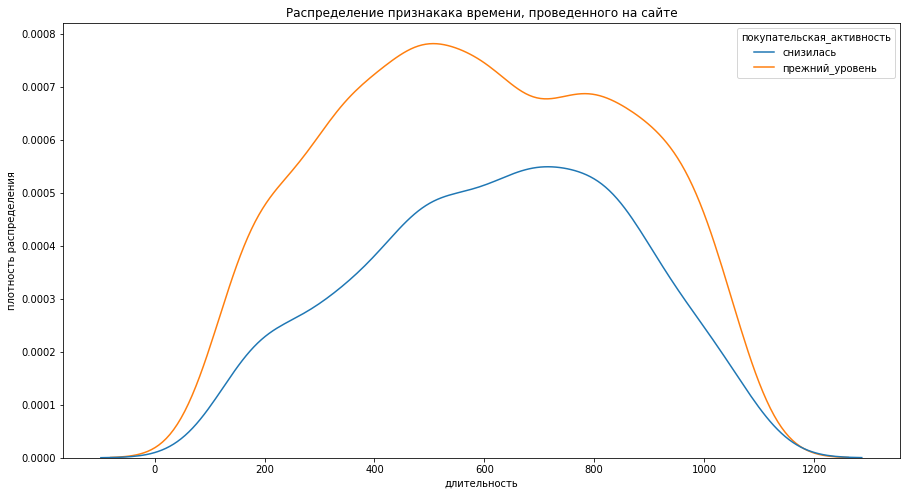

In [41]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=FileDF, x="длительность", hue="покупательская_активность")
plt.title('Распределение признакака времени, проведенного на сайте')
plt.xlabel('длительность')
plt.ylabel('плотность распределения')
plt.show()

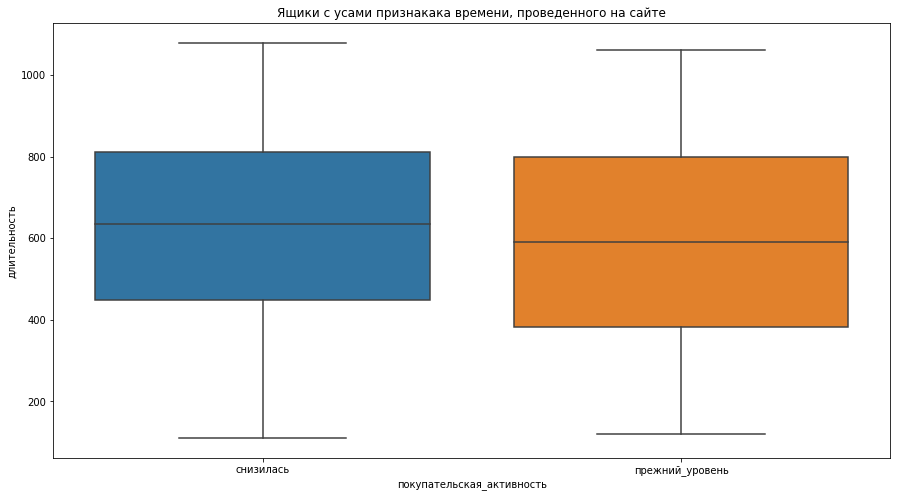

In [42]:
plt.figure(figsize=(15,8))
sns.boxplot(data=FileDF, x="покупательская_активность",  y="длительность")
plt.title('Ящики с усами признакака времени, проведенного на сайте')
plt.xlabel('покупательская_активность')
plt.ylabel('длительность')
plt.show()

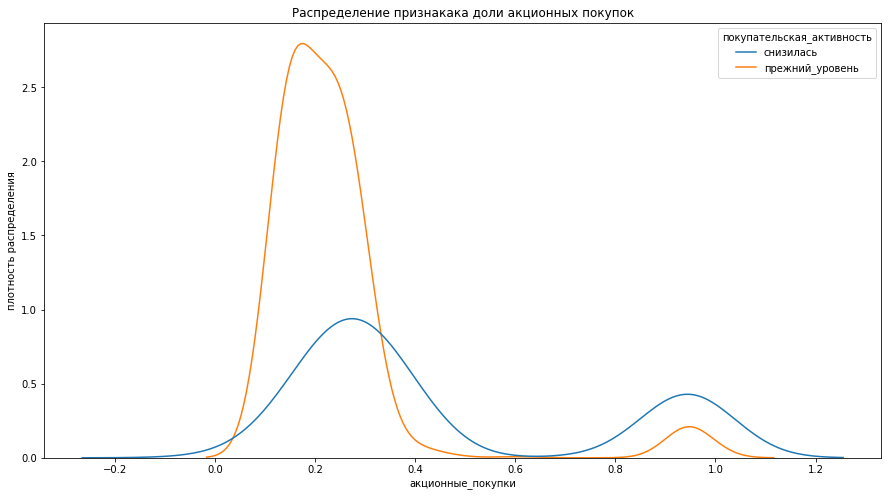

In [43]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=FileDF, x="акционные_покупки", hue="покупательская_активность")
plt.title('Распределение признакака доли акционных покупок')
plt.xlabel('акционные_покупки')
plt.ylabel('плотность распределения')
plt.show()

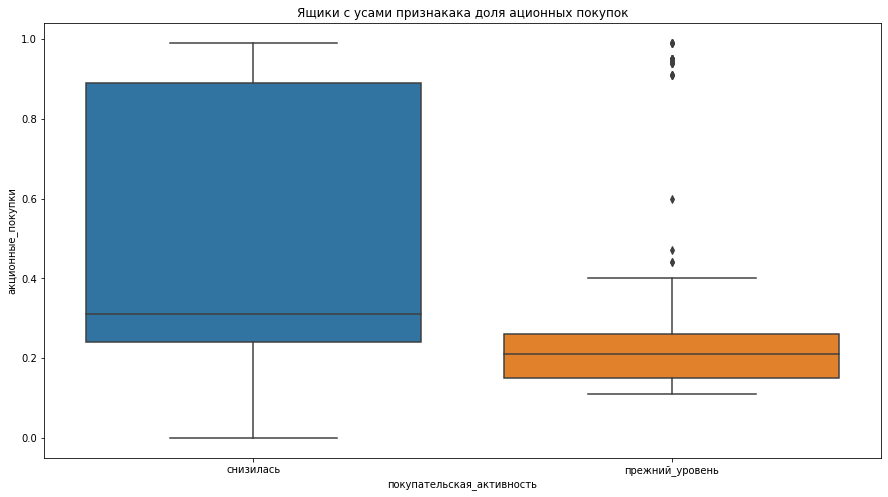

In [44]:
plt.figure(figsize=(15,8))
sns.boxplot(data=FileDF, x="покупательская_активность",  y="акционные_покупки")
plt.title('Ящики с усами признакака доля ационных покупок')
plt.xlabel('покупательская_активность')
plt.ylabel('акционные_покупки')
plt.show()

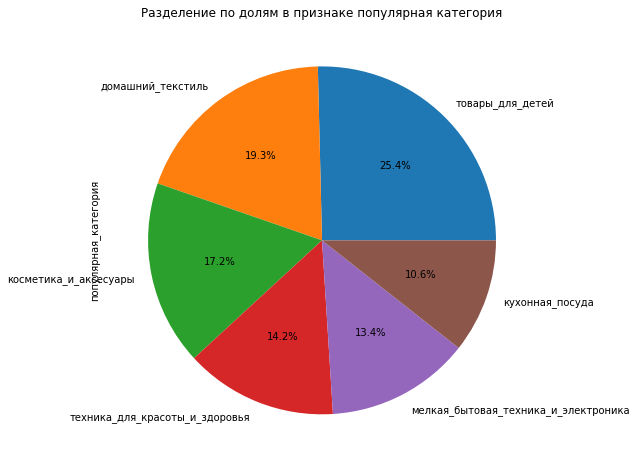

In [45]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке популярная категория')
pie=FileDF['популярная_категория'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

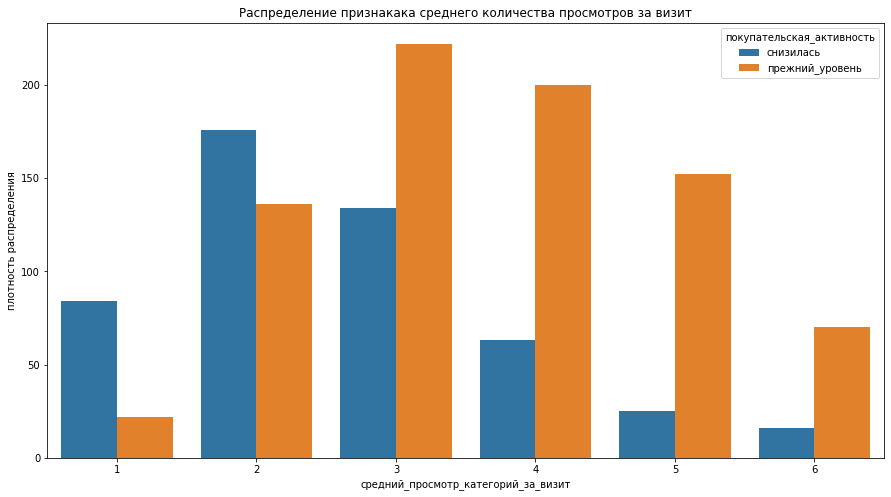

In [46]:
plt.figure(figsize=(15,8))
sns.countplot(data=FileDF, x="средний_просмотр_категорий_за_визит", hue="покупательская_активность")
plt.title('Распределение признакака среднего количества просмотров за визит')
plt.xlabel('средний_просмотр_категорий_за_визит')
plt.ylabel('плотность распределения')
plt.show()

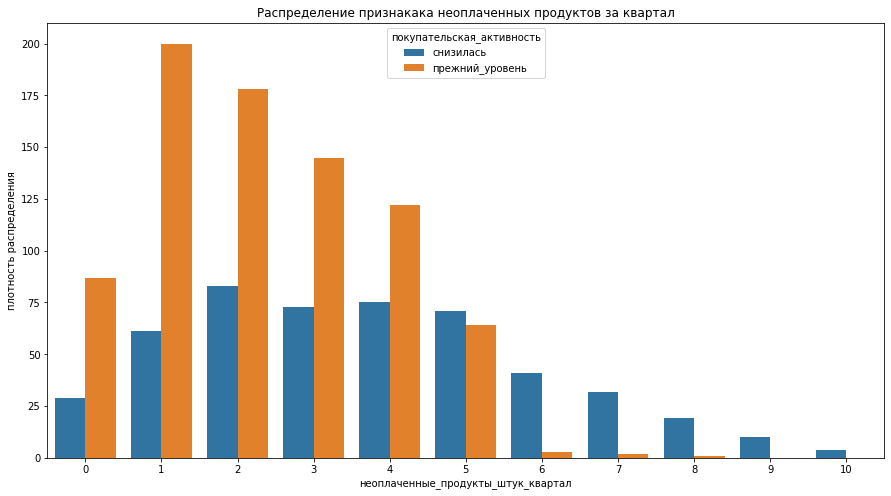

In [47]:
plt.figure(figsize=(15,8))
sns.countplot(data=FileDF, x="неоплаченные_продукты_штук_квартал", hue="покупательская_активность")
plt.title('Распределение признакака неоплаченных продуктов за квартал')
plt.xlabel('неоплаченные_продукты_штук_квартал')
plt.ylabel('плотность распределения')
plt.show()

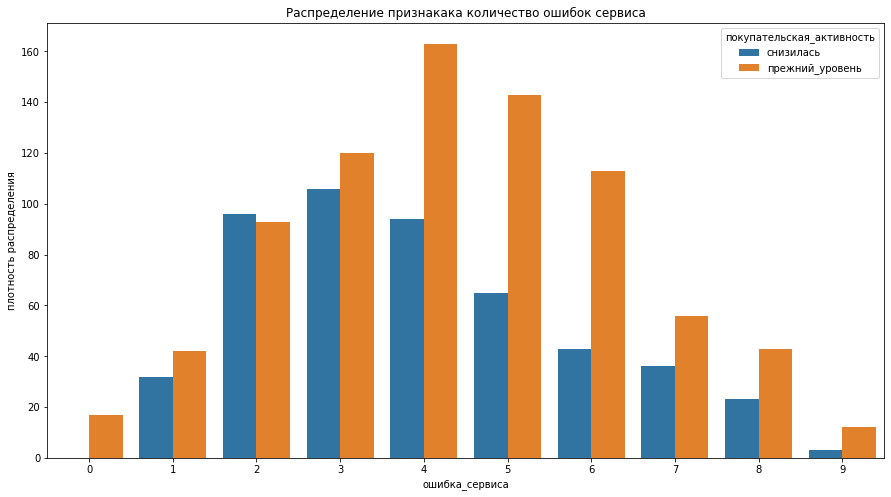

In [48]:
plt.figure(figsize=(15,8))
sns.countplot(data=FileDF, x="ошибка_сервиса", hue="покупательская_активность")
plt.title('Распределение признакака количество ошибок сервиса')
plt.xlabel('ошибка_сервиса')
plt.ylabel('плотность распределения')
plt.show()

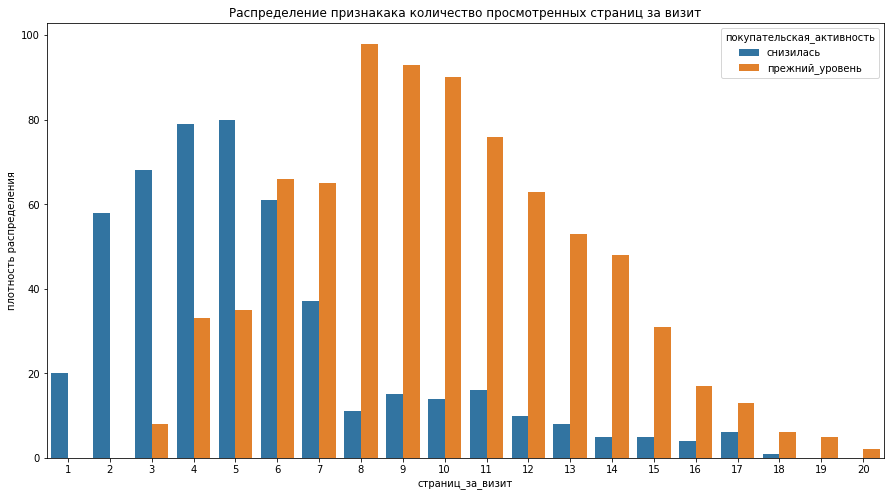

In [49]:
plt.figure(figsize=(15,8))
sns.countplot(data=FileDF, x="страниц_за_визит", hue="покупательская_активность")
plt.title('Распределение признакака количество просмотренных страниц за визит')
plt.xlabel('страниц_за_визит')
plt.ylabel('плотность распределения')
plt.show()

При более близком рассмотрении признаков видно:

* Есть дисбаланс классов в целевом признаке

* Снизилась покупательская активность у пользователей, которые просматривают меньше страниц за визит

* Снизилась покупательская активность у пользователей, которые чаще покупают акционные товары

* Снизилась покупательская активность у пользователей, у которых снизилась и активность на сайте

In [50]:
MMoneyDF

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


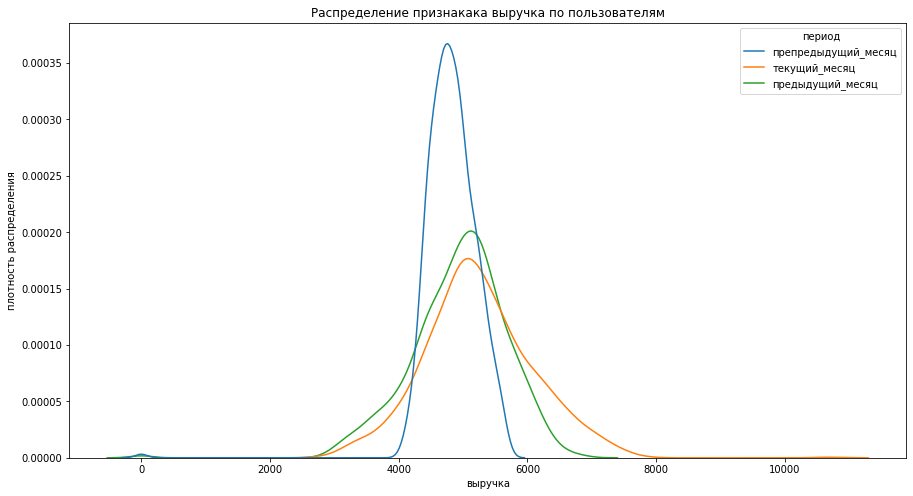

In [51]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=MMoneyDF, x="выручка", hue="период")
plt.title('Распределение признакака выручка по пользователям')
plt.xlabel('выручка')
plt.ylabel('плотность распределения')
plt.show()

Видим, что среднне значение выручки остается прежним, при этом количество индивидов уменьшается

Выручка распределена нормально

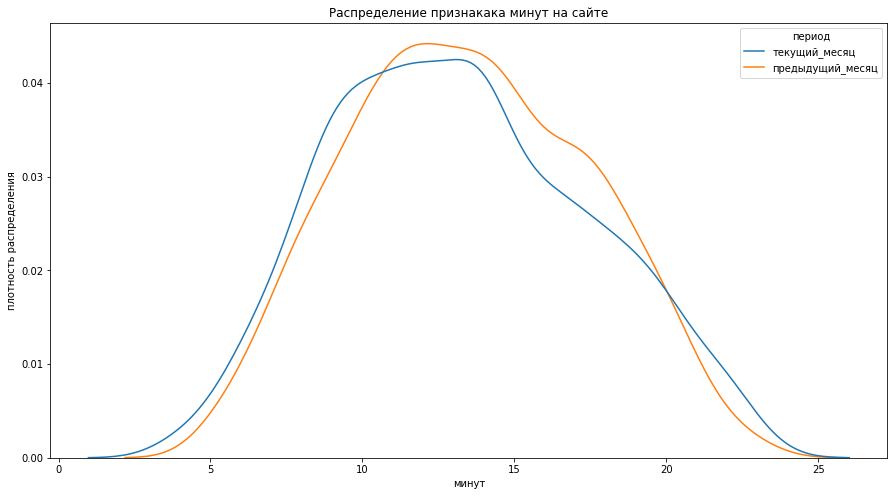

In [52]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=TimeDF, x="минут", hue="период")
plt.title('Распределение признакака минут на сайте')
plt.xlabel('минут')
plt.ylabel('плотность распределения')
plt.show()

Видим, что распределение исследуемого признака не изменяется от периода к периоду

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Время, проведенное на сайте, распределено нормально для каждого из периодов, при этом, распределения каждого из периодов почти совпадают друг другу

Проверим гипотезу о нормальности распределения времени, проведенного на сайте

In [55]:
stat, p = shapiro(TimeDF["минут"])
alpha = 0.05 
print(f'Статистика теста Шапиро-Уилка: {stat}, p-значение: {p}')
if p > alpha:
    print("Гипотеза о нормальности не отвергается.")
else:
    print("Гипотеза о нормальности отвергается.")

Статистика теста Шапиро-Уилка: 0.9825971126556396, p-значение: 2.538257641794904e-17
Гипотеза о нормальности отвергается.


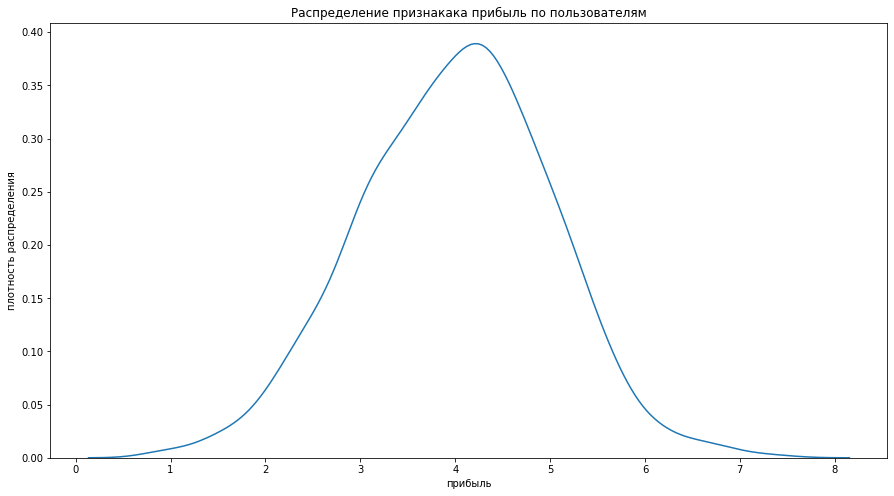

In [54]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=MoneyDF, x="прибыль")
plt.title('Распределение признакака прибыль по пользователям')
plt.xlabel('прибыль')
plt.ylabel('плотность распределения')
plt.show()

Распределение прибыли визуально симметричное, близкое к нормальному. Проверим это

In [56]:
stat, p = shapiro(MoneyDF["прибыль"])
alpha = 0.05 
print(f'Статистика теста Шапиро-Уилка: {stat}, p-значение: {p}')
if p > alpha:
    print("Гипотеза о нормальности не отвергается.")
else:
    print("Гипотеза о нормальности отвергается.")

Статистика теста Шапиро-Уилка: 0.9983817934989929, p-значение: 0.2580398917198181
Гипотеза о нормальности не отвергается.


Мы не можем отвергунть гипотезу, что распределение прибыли нормальное, воспользуемся тестом Колмогорова-Смирнова

In [59]:
stat, p = kstest(MoneyDF["прибыль"], 'norm')
print(f'Статистика теста Колмогорова-Смирнова: {stat}, p-значение: {p}')
if p > alpha:
    print("Гипотеза о нормальности не отвергается.")
else:
    print("Гипотеза о нормальности отвергается.")

Статистика теста Колмогорова-Смирнова: 0.9534037142056669, p-значение: 0.0
Гипотеза о нормальности отвергается.


В данном разделе мы убедились, что задача выполнима, а именно - существует связь между целевым признаком и собранными данными. Также, мы убедились, что распределение не является нормальным. Тест Колмогор

# Шаг 4. Объединение таблиц

In [55]:
MMoneyDF = MMoneyDF.rename(columns={'период': 'период_выручка'})

In [56]:
TimeDF = TimeDF.rename(columns={'период': 'период_минут'})

In [57]:
MMoneyDF = MMoneyDF.pivot(index='id', columns='период_выручка', values='выручка').reset_index()

In [58]:
TimeDF = TimeDF.pivot(index='id', columns='период_минут', values='минут').reset_index()

In [59]:
MMoneyDF = MMoneyDF.rename(columns={'предыдущий_месяц': 'предыдущий_месяц_выручка', 'препредыдущий_месяц':'препредыдущий_месяц_выручка','текущий_месяц':'текущий_месяц_выручка'})

In [60]:
TimeDF = TimeDF.rename(columns={'предыдущий_месяц': 'предыдущий_месяц_минут',
                                         'текущий_месяц':'текущий_месяц_минут'})

In [61]:
MMoneyDF

период_выручка,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7
1296,216644,4729.0,5299.0,5353.0
1297,216645,5160.0,5334.0,5139.2
1298,216646,4923.0,4725.0,5224.6


In [62]:
MMoneyDF.replace(0, np.nan, inplace=True)

In [63]:
TimeDF

период_минут,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [64]:
TimeDF.replace(0, np.nan, inplace=True)

In [65]:
AllDF = FileDF.merge(MMoneyDF, on='id', how='left')
AllDF  = AllDF .merge(TimeDF, on='id', how='left')

In [66]:
AllDF.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               3
препредыдущий_месяц_выручка            3
текущий_месяц_выручка                  0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

In [67]:
AllDF.dropna()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,прежний_уровень,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [68]:
AllDF.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               3
препредыдущий_месяц_выручка            3
текущий_месяц_выручка                  0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

В данном разделе был собран датафрейм, объединяющий все необходимые данные

# Шаг 5. Корреляционный анализ

Построем корреляционную матрицу, используя коэффициент корреляции Спирмена

/tmp/ipykernel_109/1846131634.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(AllDF.drop('id', axis = 1).corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')


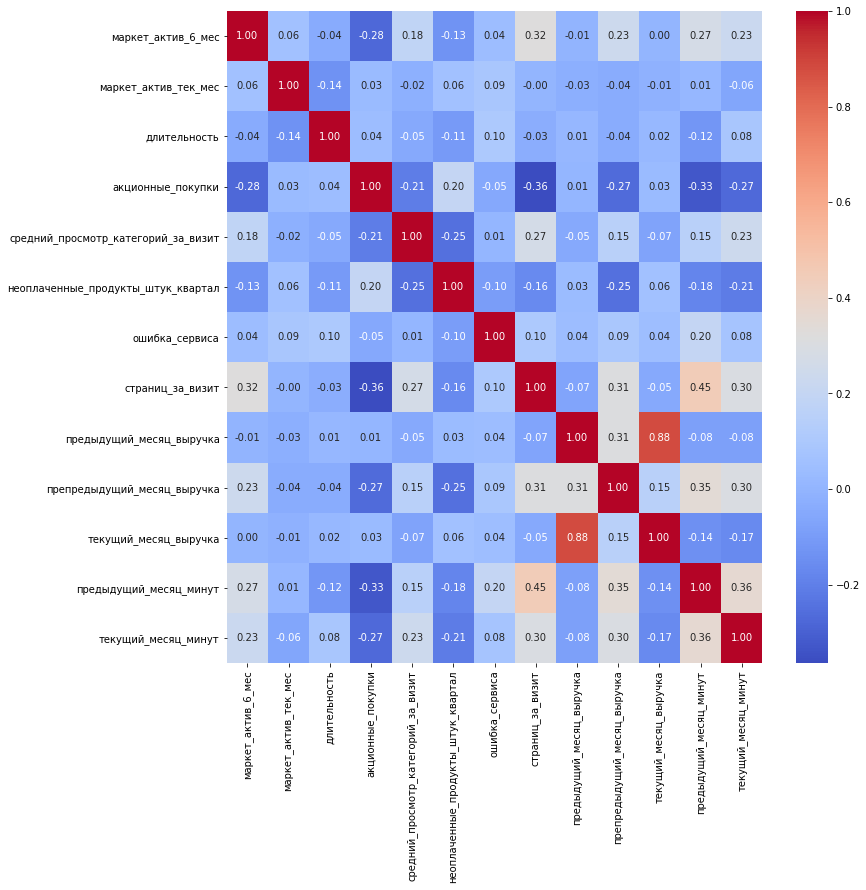

In [69]:
plt.figure(figsize=(12,12))
sns.heatmap(AllDF.drop('id', axis = 1).corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.show();

Видим сильную корреляцию между "текущий_месяц_выручка" и "предыдущий_месяц_выручка". Удалим столбец "текущий_месяц_выручка", к тому же, данный столбец явно связан с целевым признаком об активности

In [70]:
AllDF = AllDF.drop('текущий_месяц_выручка', axis = 1)

# Шаг 6. Использование пайплайнов

In [71]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [72]:
original_classes = ['снизилась', 'прежний_уровень']

encoder = LabelEncoder()
encoder.classes = np.array(original_classes) 

X = AllDF.drop(['покупательская_активность'], axis=1)
X = X.drop(['id'], axis=1)
y = encoder.fit_transform(AllDF['покупательская_активность'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [74]:
X_train.shape

(975, 15)

In [75]:
X_test.shape

(325, 15)

In [76]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
standard_num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит']
minmax_num_columns = ['предыдущий_месяц_минут','текущий_месяц_минут',
               'предыдущий_месяц_выручка','препредыдущий_месяц_выручка']

In [77]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan,
                categories = [['стандарт', 'премиум'], ['нет', 'да']]
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [78]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('st_num', StandardScaler(), standard_num_columns),
     ('mm_num', MinMaxScaler(), minmax_num_columns)
    ], 
    remainder='passthrough'
)

In [79]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [80]:
param_grid = [
    # {
    #     'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    #     'models__max_depth': range(2, 5),
    #     'models__max_features': range(2, 5)
    # },
    # {
    #     'models': [KNeighborsClassifier()],
    #     'models__n_neighbors': range(5, 100)
    # },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0, 100.0]
    },
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]


Будем использовать метрику ROC-AUC, так как он даёт более комплексную и точную оценку производительности модели. А также не чувствителен к несбалансированности выборки

In [81]:
randomized_search =  GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
   # random_state=RANDOM_STATE,
    n_jobs=-1
)

In [82]:
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImpu...
             param_grid=[{'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(2, 5),
                          'models__max_features': range(2, 5)},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(5, 100)},
                         {'models': [LogisticRegression(random_state=42)],
                          'models__C': [0.1, 1.0, 10.0, 100.0]},
                         {'models': [SVC(probability=True)],
                          'models__kernel': ['linear', 'rbf']}],
             scoring='roc_auc')

In [83]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:, 1] 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'...
    

# Шаг 7. Анализ важности признаков

In [84]:
model = randomized_search.best_estimator_.named_steps['models']

In [85]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)
X_train_preprocessed = preprocessor.transform(X_train)

In [86]:
all_feature_names = preprocessor.get_feature_names_out()

In [87]:
all_feature_names

array(['ohe__популярная_категория_косметика_и_аксесуары',
       'ohe__популярная_категория_кухонная_посуда',
       'ohe__популярная_категория_мелкая_бытовая_техника_и_электроника',
       'ohe__популярная_категория_техника_для_красоты_и_здоровья',
       'ohe__популярная_категория_товары_для_детей', 'ord__тип_сервиса',
       'ord__разрешить_сообщать', 'st_num__маркет_актив_6_мес',
       'st_num__маркет_актив_тек_мес', 'st_num__длительность',
       'st_num__акционные_покупки',
       'st_num__средний_просмотр_категорий_за_визит',
       'st_num__неоплаченные_продукты_штук_квартал',
       'st_num__ошибка_сервиса', 'st_num__страниц_за_визит',
       'mm_num__предыдущий_месяц_минут', 'mm_num__текущий_месяц_минут',
       'mm_num__предыдущий_месяц_выручка',
       'mm_num__препредыдущий_месяц_выручка'], dtype=object)

In [88]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed,  columns=all_feature_names)
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed,  columns=all_feature_names)
X_test_shap = shap.sample(X_test_preprocessed_df, 10, random_state=RANDOM_STATE)
X_train_shap = shap.sample(X_train_preprocessed_df, 10, random_state=RANDOM_STATE)

In [89]:
X_test_shap

,ohe__популярная_категория_косметика_и_аксесуары,ohe__популярная_категория_кухонная_посуда,ohe__популярная_категория_мелкая_бытовая_техника_и_электроника,ohe__популярная_категория_техника_для_красоты_и_здоровья,ohe__популярная_категория_товары_для_детей,ord__тип_сервиса,ord__разрешить_сообщать,st_num__маркет_актив_6_мес,st_num__маркет_актив_тек_мес,st_num__длительность,st_num__акционные_покупки,st_num__средний_просмотр_категорий_за_визит,st_num__неоплаченные_продукты_штук_квартал,st_num__ошибка_сервиса,st_num__страниц_за_визит,mm_num__предыдущий_месяц_минут,mm_num__текущий_месяц_минут,mm_num__предыдущий_месяц_выручка,mm_num__препредыдущий_месяц_выручка
234,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.056093,-0.033745,1.496862,-0.841391,-0.936221,-1.440291,-1.132137,-0.795670,0.722222,0.578947,0.399548,0.688020
110,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.931930,1.396763,0.839392,-0.841391,0.548032,-0.935697,1.972880,-0.795670,0.388889,0.789474,0.388994,0.885971
248,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.153409,-1.464253,0.692848,-0.682845,0.548032,-0.431104,-0.097131,-1.047056,0.166667,0.947368,0.653851,0.179372
9,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.153409,-1.464253,0.728494,-0.365753,-0.936221,-0.935697,0.937874,-0.544284,0.444444,0.842105,0.580098,0.968610
93,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.430482,-0.033745,-0.012150,-0.801755,-0.936221,0.073489,-0.097131,1.969580,0.666667,0.263158,0.770825,0.676489
219,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.500949,-0.033745,-1.010237,-0.801755,1.290158,0.073489,-0.614634,0.209875,0.111111,0.421053,0.625330,0.778347
287,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.209004,-0.033745,0.007653,-0.563936,-0.936221,0.073489,0.937874,0.712648,0.722222,0.736842,0.414876,0.777066
198,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.153409,-1.464253,0.843353,-0.405390,-0.194095,0.073489,-0.097131,-0.795670,0.388889,0.210526,0.631612,0.504164
203,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.737300,-1.464253,0.795825,-0.405390,1.290158,-0.935697,-0.097131,-0.544284,0.111111,0.789474,0.429954,0.333760
101,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.792895,-0.033745,-1.196388,-0.207207,2.032285,0.073489,0.937874,1.969580,0.777778,0.526316,0.537379,0.600256


In [90]:
explainer = shap.KernelExplainer(model.predict_proba, X_train_shap)
shap_values = explainer(X_test_shap)

  0%|          | 0/10 [00:00<?, ?it/s]

In [91]:
shap_values

.values =
array([[[ 0.00000000e+00,  0.00000000e+00],
        [-1.18805430e-03,  1.18805430e-03],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [-6.58534002e-03,  6.58534002e-03],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.14732444e-03,  1.14732444e-03],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 2.57647318e-01, -2.57647318e-01],
        [ 5.68635620e-04, -5.68635620e-04],
        [ 5.13789406e-04, -5.13789406e-04],
        [ 5.54798217e-04, -5.54798217e-04],
        [-6.77106661e-03,  6.77106661e-03],
        [ 5.82374541e-02, -5.82374541e-02],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 1.78349110e-02, -1.78349110e-02]],

       [[-8.49882765e-04,  8.49882765e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000

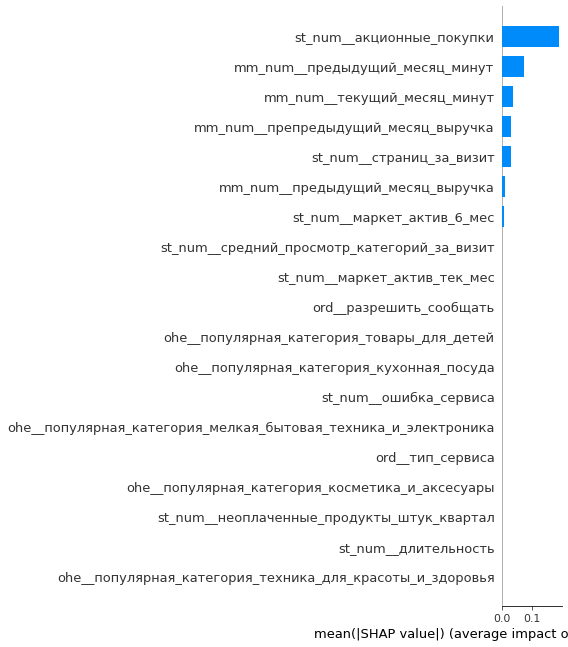

In [92]:
shap.summary_plot(shap_values[:, :, 1], X_test_shap, plot_type="bar", max_display=30)

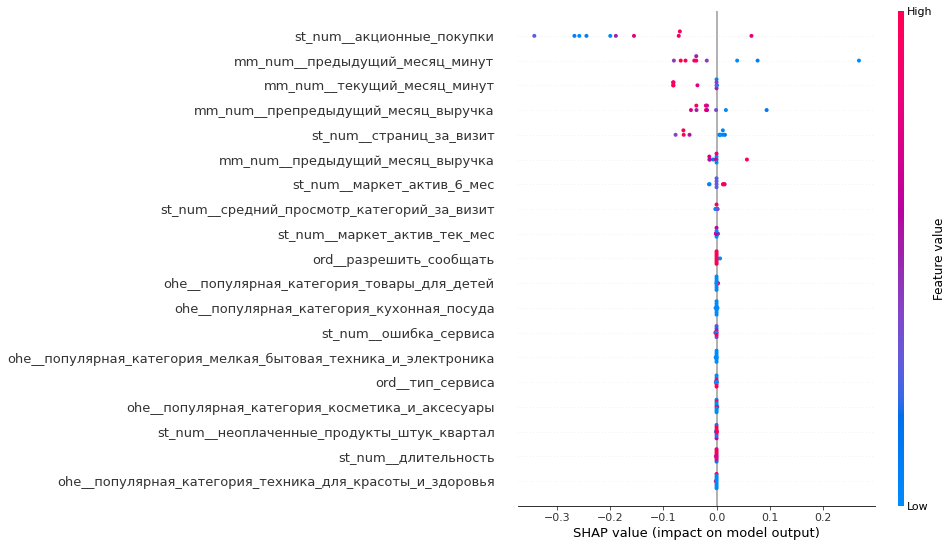

In [93]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=19)

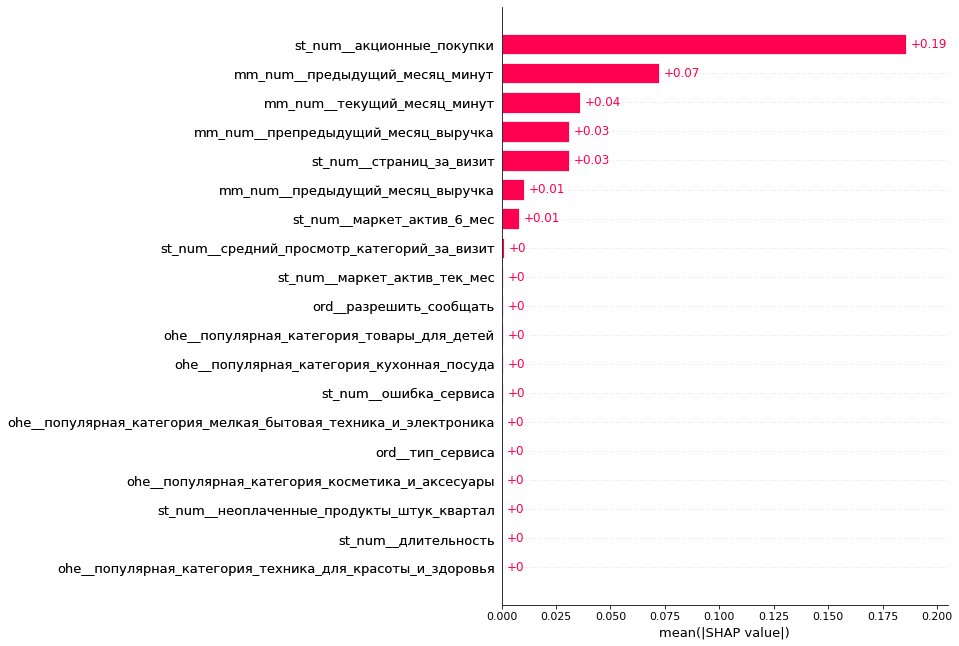

In [94]:
shap.plots.bar(shap_values[:, :, 1], max_display=19) 

Самые значимые признаки:

* доля акционных покупок - чем меньше значение, тем с меньшей вероятностью активность клиента снизилась
* предыдущий месяц минут - чем больше значение, тем с меньшей вероятностью активность клиента снизилась
* текущий месяц минут - чем больше значение, тем с меньшей вероятностью активность клиента снизилась
* страниц за визит - чем больше значение, тем с меньшей вероятностью активность клиента снизилась

# Шаг 8. Сегментация покупателей

Рассмотрим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

In [95]:
MoneyDF.drop('id', axis=1).describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Возьмем четвертый квантиль данной выборки, как самых прибыльных клиентов 

In [96]:
HighMoneyDF = MoneyDF.loc[MoneyDF['прибыль'] > 4.670000]

In [97]:
HighMoneyDF.drop('id', axis=1).describe()

,прибыль
count,324.000000
mean,5.257994
std,0.493157
min,4.680000
25%,4.880000
50%,5.130000
75%,5.490000
max,7.430000


Теперь выберем из предсказанных значений индивидов с большой вероятностью снижения покупательской активности

In [98]:
threshold = 0.9
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)
HighProbaDF = AllDF.loc[prediction_flags]
result = HighProbaDF[HighProbaDF['id'].isin(HighMoneyDF['id'])]
result

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,11,13
7,215355,снизилась,стандарт,нет,4.7,4,284,0.17,товары_для_детей,5,1,6,4,3263.0,4749.0,12,10
11,215359,снизилась,стандарт,да,4.6,5,110,0.00,домашний_текстиль,4,2,4,2,NaN,NaN,13,11
36,215384,снизилась,стандарт,да,4.0,4,1020,0.34,косметика_и_аксесуары,2,3,8,3,3584.0,4226.0,11,12
40,215388,снизилась,стандарт,да,3.5,4,663,0.99,домашний_текстиль,4,2,2,2,3188.0,4182.0,10,12
42,215390,снизилась,стандарт,да,3.1,4,152,0.33,косметика_и_аксесуары,6,4,2,5,4254.0,4549.0,8,12
52,215400,снизилась,стандарт,нет,4.4,5,304,0.94,товары_для_детей,1,4,3,2,5681.0,4439.0,11,9
70,215418,снизилась,стандарт,нет,1.7,4,472,0.94,домашний_текстиль,2,6,4,3,5943.5,4661.0,8,11
89,215437,снизилась,премиум,да,2.4,3,602,0.32,косметика_и_аксесуары,2,5,3,3,4987.5,4875.0,10,6
92,215440,снизилась,стандарт,нет,3.8,5,344,0.40,товары_для_детей,3,3,8,3,5470.5,4740.0,7,7


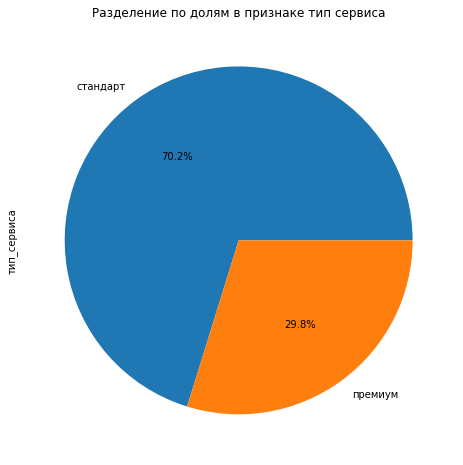

In [99]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке тип сервиса')
pie=result['тип_сервиса'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

Видим, что в соотношении 3 к 1 преобладают покупатели со стандартным сервисом

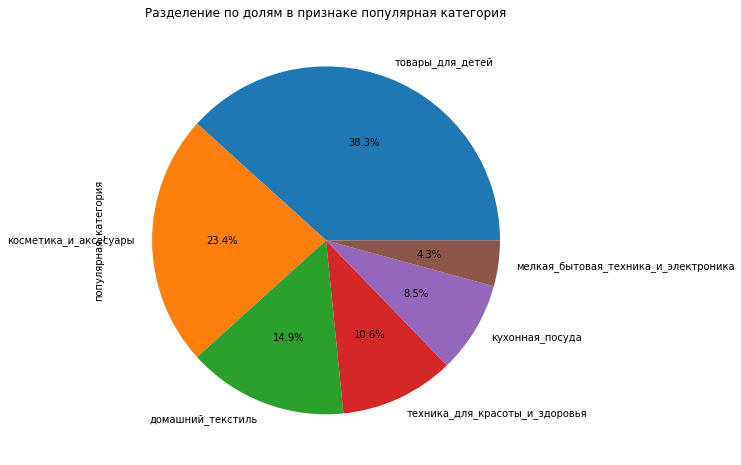

In [100]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке популярная категория')
pie=result['популярная_категория'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

Преобладают товары для детей

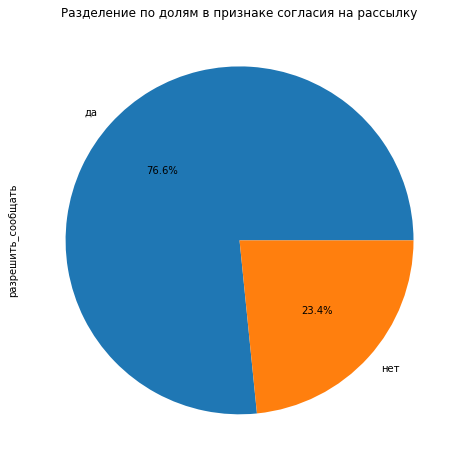

In [101]:
plt.figure(figsize=(15,8))
plt.title('Разделение по долям в признаке согласия на рассылку')
pie=result['разрешить_сообщать'].value_counts()
pie.plot(kind='pie',autopct='%1.1f%%')
plt.show()

Видим, что бльшинство выбранных индивидов ожидают уведомления о скидкаих и акциях от магазина

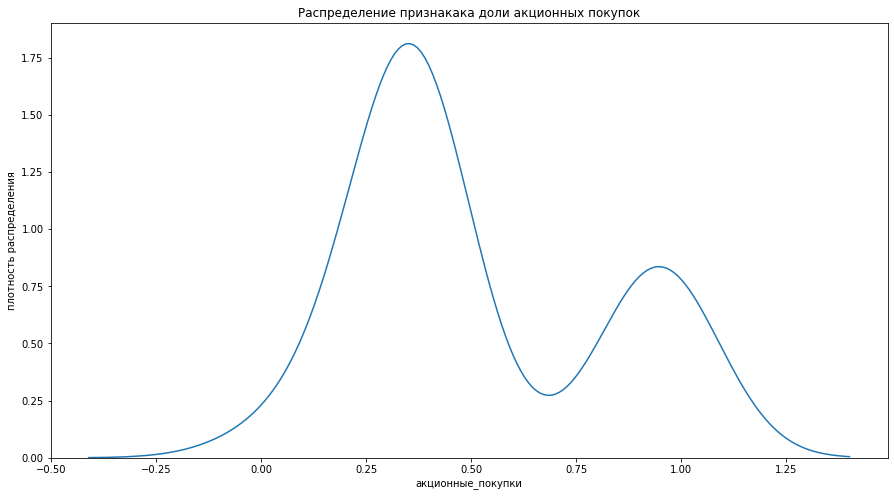

In [102]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=result, x="акционные_покупки")
plt.title('Распределение признакака доли акционных покупок')
plt.xlabel('акционные_покупки')
plt.ylabel('плотность распределения')
plt.show()

Видим, что покупательская активность среди тех кто покупал много и дорого снижается либо у тех, кто все покупал по скидке, либо у тех, кто покупал только меньшую часть вещей по скидке

In [103]:
result.drop('id', axis = 1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,46.000000,46.000000,47.000000,47.000000
mean,3.487234,4.212766,610.978723,0.513191,2.595745,3.723404,3.765957,4.106383,4702.978261,4578.260870,9.744681,9.957447
std,1.104461,0.657273,260.606357,0.296201,1.361897,2.123391,1.683846,1.618293,903.893043,239.782349,1.893560,2.166518
min,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2909.000000,4182.000000,6.000000,6.000000
25%,2.900000,4.000000,365.000000,0.330000,2.000000,2.000000,3.000000,3.000000,3997.500000,4368.500000,8.000000,9.000000
50%,3.800000,4.000000,666.000000,0.390000,2.000000,4.000000,4.000000,4.000000,4840.750000,4609.500000,10.000000,10.000000
75%,4.100000,5.000000,826.000000,0.890000,3.000000,5.000000,5.000000,5.000000,5382.875000,4746.750000,11.000000,12.000000
max,5.600000,5.000000,1073.000000,0.990000,6.000000,9.000000,8.000000,8.000000,6227.000000,4990.000000,13.000000,14.000000


Исследование параметров распределений признаков, а именно оценка средких, показало, что на выручка от таких покупателей и активность на сайте пока не упали

На основе анализа сегмента можно сделать вывод, что магазину необходимо либо увеличить число акционных товаров, либо улучшить систему уведомлений для таких покупателей

# Шаг 9. Общий вывод

В данной работе решалась задача объяснения снижения покупательской активности среди пользователей интернет магазина

Для решения поставленной задачи исследовались данные об активности покупателей на сайте, а именно:

#### market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 * id — номер покупателя в корпоративной базе данных.
 * Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 * Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 * Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
 * Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 * Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 * Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 * Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 * Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 * Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 * Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 * Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 * Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

 * id — номер покупателя в корпоративной базе данных.
 * Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 * Выручка — сумма выручки за период.

#### market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 
 * id — номер покупателя в корпоративной базе данных.
 * Период — название периода, во время которого зафиксировано общее время.
 * минут — значение времени, проведённого на сайте, в минутах.

#### money.csv - Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

 * id — номер покупателя в корпоративной базе данных.
 * Прибыль — значение прибыли.

Перед началом работы названия всех столбцов, а также вид категориальных значений в столбцах были приведены к одному виду

Для исследования влияния признаков на снижение активности было решено провести интерпритацию модели машинного обучения, которая лучше всего бы предсказывала целевую категорию

Для этого был построен пайплайн, который проводил кодирование входных признаков, а также перебирал модели машинного обучния и гиперпараметры к ним, а именно:

логистическая регрессия,

метод опорных векторов,

метод К-средних,

решающее дерево

Лучшей оказалась модель основанная на метода деревьев поиска

Интерпритация модели показала, что сильнее всего на снижение активности влияет доля акционных товаров, а количество страниц магазина, которое в среднем смотрит клиент. При чем было совершено наблюдение, что если клиент мало покупал что-то по акции, то скорее всего его активность не упала.

Можем дать магазину общую рекомендацию провести распродажу.

Далее была рассмотрена группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

В ходе исследования стало ясно, что больше всего денег магазину, среди тех, чья активность снизилась, приносят покупатели "охотящиеся" на скидки, отсюда магазину дана рекомендация о проведении акционных кампаний и о более качественном доведении информации для таких клиентов